In [ ]:

#@title 链接Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#@title cgan训练

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


class Generator(nn.Module):
    def __init__(self, noise_dim, num_classes):
        super(Generator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(noise_dim + num_classes, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 28 * 28),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_input = self.label_embedding(labels)
        input = torch.cat((noise, label_input), dim=1)
        return self.model(input).view(input.size(0), 1, 28, 28)


class Discriminator(nn.Module):
    def __init__(self, num_classes):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(28 * 28 + num_classes, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_input = self.label_embedding(labels)
        input = torch.cat((img.view(img.size(0), -1), label_input), dim=1)
        return self.model(input)


noise_dim = 100
num_classes = 10
lr = 0.0002
batch_size = 64
epochs = 50

generator = Generator(noise_dim, num_classes).to(device)
discriminator = Discriminator(num_classes).to(device)

optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

criterion = nn.BCELoss()

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


for epoch in range(epochs):
    for i, (imgs, labels) in enumerate(train_loader):
        batch_size = imgs.size(0)

        # 真实标签为1，假标签为0
        real = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        # 训练判别器
        real_imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer_d.zero_grad()

        outputs = discriminator(real_imgs, labels)
        d_loss_real = criterion(outputs, real)

        z = torch.randn(batch_size, noise_dim).to(device)
        gen_labels = torch.randint(0, num_classes, (batch_size,)).to(device)
        fake_imgs = generator(z, gen_labels)

        outputs = discriminator(fake_imgs.detach(), gen_labels)
        d_loss_fake = criterion(outputs, fake)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_d.step()

        # 训练生成器
        optimizer_g.zero_grad()

        outputs = discriminator(fake_imgs, gen_labels)
        g_loss = criterion(outputs, real)

        g_loss.backward()
        optimizer_g.step()

    print(f"Epoch [{epoch + 1}/{epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}")

    if epoch % 10 == 0:
        with torch.no_grad():
            z = torch.randn(batch_size, noise_dim).to(device)
            gen_labels = torch.randint(0, num_classes, (batch_size,)).to(device)
            generated_imgs = generator(z, gen_labels).cpu()
            plt.figure(figsize=(10, 10))
            for k in range(25):
                plt.subplot(5, 5, k+1)
                plt.imshow(generated_imgs[k].squeeze(), cmap='gray')
                plt.axis('off')
            plt.show()



In [ ]:
#@title cgan彩色

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

noise_dim = 100
num_classes = 10
lr = 0.0002
batch_size = 64
epochs = 50

class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes, img_shape):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.img_shape = img_shape
        self.init_size = img_shape[1] // 4
        self.fc = nn.Sequential(nn.Linear(latent_dim + num_classes, 128 * self.init_size**2))
        self.upconv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, img_shape[0], 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        x = self.fc(gen_input)
        x = x.view(x.size(0), 128, self.init_size, self.init_size)
        img = self.upconv_blocks(x)
        return img

class Discriminator(nn.Module):
    def __init__(self, num_classes, img_shape):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(13, 64, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 3, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )
        ds_size = img_shape[1] // 2**4
        self.fc = nn.Sequential(
            nn.Linear(512 * ds_size**2, 1),
            nn.Sigmoid()  # Add Sigmoid activation here
        )

    def forward(self, img, labels):
        d_in = torch.cat((img, self.label_embedding(labels).unsqueeze(2).unsqueeze(3).expand(-1, -1, img.size(2), img.size(3))), 1)
        out = self.conv_blocks(d_in)
        out = out.view(out.shape[0], -1)
        validity = self.fc(out)
        return validity


transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


latent_dim = 100
num_classes = 10
img_shape = (3, 32, 32)

generator = Generator(latent_dim, num_classes, img_shape).to(device)
discriminator = Discriminator(num_classes, img_shape).to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()

for epoch in range(epochs):
    for i, (imgs, labels) in enumerate(train_loader):
        batch_size = imgs.size(0)
        valid = torch.ones(batch_size, 1, requires_grad=False).to(device)
        fake = torch.zeros(batch_size, 1, requires_grad=False).to(device)

        real_imgs = imgs.to(device)
        labels = labels.to(device)

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, latent_dim).to(device)
        gen_labels = torch.randint(0, num_classes, (batch_size,)).to(device)
        gen_imgs = generator(z, gen_labels)
        g_loss = criterion(discriminator(gen_imgs, gen_labels), valid)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = criterion(discriminator(real_imgs, labels), valid)
        fake_loss = criterion(discriminator(gen_imgs.detach(), gen_labels), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    print(f"[Epoch {epoch}/{epochs}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")




In [ ]:
#@title 验证模型

import matplotlib.pyplot as plt

# 生成随机噪声和随机标签
z = torch.randn(10, latent_dim).to(device)
labels = torch.arange(0, 10).to(device)  # 生成标签从0到9

# 使用生成器生成图像
gen_imgs = generator(z, labels)

# 将图像从 (-1, 1) 还原到 (0, 1)
gen_imgs = gen_imgs * 0.5 + 0.5

# 将生成的图像从 GPU 移动到 CPU，并转换为 numpy 数组
gen_imgs = gen_imgs.detach().cpu().numpy()

# 绘制生成的图像
fig, axs = plt.subplots(1, 10, figsize=(15, 15))
for i in range(10):
    axs[i].imshow(gen_imgs[i].transpose(1, 2, 0))
    axs[i].set_title(f"Label: {labels[i].item()}")
    axs[i].axis('off')
plt.show()


## cgan处理灰度图片

In [ ]:
#@title 彩色图片变成灰色图片

import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 定义转换，包括将图像转换为灰度
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # 将图像转换为灰度
    transforms.Resize(32),                        # 调整大小
    transforms.ToTensor(),                        # 转换为Tensor
    transforms.Normalize([0.5], [0.5])            # 归一化到 [-1, 1]
])

# 加载CIFAR-10数据集并应用灰度转换
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 显示一些灰度图像
dataiter = iter(train_loader)
images, labels = next(dataiter)  # 使用 next() 获取下一个批次的数据

# 将图像还原到 [0, 1] 以便可视化
images = images * 0.5 + 0.5

# 显示前8个灰度图像
fig, axes = plt.subplots(1, 8, figsize=(12, 2))
for i in range(8):
    ax = axes[i]
    ax.imshow(images[i].squeeze(), cmap='gray')  # 使用灰度颜色映射
    ax.axis('off')
plt.show()



In [ ]:
#@title 训练灰度图作为条件的cgan

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# 设备配置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 超参数
latent_dim = 100
num_classes = 10
img_shape = (3, 32, 32)
batch_size = 64
epochs = 50

# Generator 网络
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()
        self.img_shape = img_shape
        self.init_size = img_shape[1] // 4
        self.fc = nn.Sequential(nn.Linear(1124, 128 * self.init_size**2))
        self.upconv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, img_shape[0], 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise, grey_image):
        gen_input = torch.cat((noise, grey_image.view(grey_image.size(0), -1)), -1)
        x = self.fc(gen_input)
        x = x.view(x.size(0), 128, self.init_size, self.init_size)
        img = self.upconv_blocks(x)
        return img

# Discriminator 网络
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(img_shape[0] + 1, 64, 3, 2, 1),  # 加1是因为拼接了灰度图
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 3, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )
        ds_size = img_shape[1] // 2**4
        self.fc = nn.Sequential(
            nn.Linear(512 * ds_size**2, 1),
            nn.Sigmoid()
        )

    def forward(self, img, grey_image):
        d_in = torch.cat((img, grey_image), 1)
        out = self.conv_blocks(d_in)
        out = out.view(out.shape[0], -1)
        validity = self.fc(out)
        return validity

# 数据转换
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

# 数据加载
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 实例化模型
generator = Generator(latent_dim, img_shape).to(device)
discriminator = Discriminator(img_shape).to(device)

# 定义模型文件的路径
generator_path = '/content/drive/MyDrive/generator_cgan_grey.pth'
discriminator_path = '/content/drive/MyDrive/discriminator_cgan_grey.pth'

# 判断文件是否存在并加载模型
if os.path.exists(generator_path):
    generator.load_state_dict(torch.load(generator_path))
    print("Generator model loaded successfully.")
else:
    print(f"Generator model file not found: {generator_path}")

if os.path.exists(discriminator_path):
    discriminator.load_state_dict(torch.load(discriminator_path))
    print("Discriminator model loaded successfully.")
else:
    print(f"Discriminator model file not found: {discriminator_path}")

# 定义优化器和损失函数
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()

# 训练循环
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(train_loader):
        batch_size = imgs.size(0)
        valid = torch.ones(batch_size, 1, requires_grad=False).to(device)
        fake = torch.zeros(batch_size, 1, requires_grad=False).to(device)

        real_imgs = imgs.to(device)
        grey_imgs = torch.mean(real_imgs, dim=1, keepdim=True).to(device)

        # 训练生成器
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, latent_dim).to(device)
        gen_imgs = generator(z, grey_imgs)
        g_loss = criterion(discriminator(gen_imgs, grey_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # 训练判别器
        optimizer_D.zero_grad()
        real_loss = criterion(discriminator(real_imgs, grey_imgs), valid)
        fake_loss = criterion(discriminator(gen_imgs.detach(), grey_imgs), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    print(f"[Epoch {epoch}/{epochs}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")


    # 每个 epoch 保存一次模型
    torch.save(generator.state_dict(), f'/content/drive/MyDrive/generator_cgan_grey.pth')
    torch.save(discriminator.state_dict(), f'/content/drive/MyDrive/discriminator_cgan_grey.pth')


In [ ]:
#@title 验证模型

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


def load_image(image_path, img_shape):
    # 使用 Pillow 加载图像
    image = Image.open(image_path).convert('RGBA')
    # 将图像调整为所需的尺寸
    image = image.resize((img_shape[1], img_shape[2]))
    # 转换为 Tensor
    transform = transforms.ToTensor()
    image = transform(image)
    # 转换为灰度图像
    image = torch.mean(image, dim=0, keepdim=True)  # 灰度图像
    return image

def save_generated_images(generator, epoch, latent_dim, num_classes, img_shape):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(64, latent_dim).to(device)
        labels = torch.randint(0, num_classes, (16,)).to(device)

        # # 使用 DataLoader 迭代器
        # dataiter = iter(train_loader)
        # test_imgs, test_labels = next(dataiter)

        # real_imgs = test_imgs.to(device)
        # grey_imgs = torch.mean(real_imgs, dim=1, keepdim=True).to(device)

        # 从本地加载图像
        grey_imgs = load_image("ok.png", img_shape).unsqueeze(0).to(device)
        grey_imgs = grey_imgs.repeat(64, 1, 1, 1)  # 扩展为批量大小为 64
        gen_imgs = generator(z, grey_imgs)

        # gen_imgs = generator(z, torch.mean(torch.randn(16, 3, img_shape[1], img_shape[2]), dim=1, keepdim=True).to(device))
        gen_imgs = (gen_imgs + 1) / 2  # Rescale images from [-1, 1] to [0, 1]

        fig, axs = plt.subplots(4, 4, figsize=(8, 8))
        cnt = 0
        for i in range(4):
            for j in range(4):
                axs[i, j].imshow(np.transpose(grey_imgs[cnt].cpu().numpy(), (1, 2, 0)))
                axs[i, j].axis('off')
                cnt += 1
        plt.savefig(f'images/{epoch}.png')
        plt.show()

        fig, axs = plt.subplots(4, 4, figsize=(8, 8))
        cnt = 0
        for i in range(4):
            for j in range(4):
                axs[i, j].imshow(np.transpose(real_imgs[cnt].cpu().numpy(), (1, 2, 0)))
                axs[i, j].axis('off')
                cnt += 1
        plt.savefig(f'images/{epoch}.png')
        plt.show()

        print("grey shape: ", grey_imgs[0].shape)
        fig, axs = plt.subplots(4, 4, figsize=(8, 8))
        cnt = 0
        for i in range(4):
            for j in range(4):
                axs[i, j].imshow(np.transpose(gen_imgs[cnt].cpu().numpy(), (1, 2, 0)))
                axs[i, j].axis('off')
                cnt += 1
        plt.savefig(f'images/{epoch}.png')
        plt.show()

# Example usage:
save_generated_images(generator, epoch, latent_dim, num_classes, img_shape)


## 超分

In [54]:
#@title 训练灰度图作为条件的cgan

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
import torch.nn.functional as F

# 设备配置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 超参数
latent_dim = 100
num_classes = 10
img_shape = (3, 32, 32)
batch_size = 64
epochs = 50

# Generator 网络
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()
        self.img_shape = img_shape
        self.init_size = img_shape[1] // 4
        self.fc = nn.Sequential(nn.Linear(3172, 128 * self.init_size**2))
        self.upconv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, img_shape[0], 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise, grey_image):
        grey_image = F.interpolate(grey_image, scale_factor=2, mode='bilinear', align_corners=False).to(device)
        # print("  1 grey_image shape:", grey_image.shape)
        gen_input = torch.cat((noise, grey_image.view(grey_image.size(0), -1)), -1)
        x = self.fc(gen_input)
        x = x.view(x.size(0), 128, self.init_size, self.init_size)
        img = self.upconv_blocks(x)
        return img

# Discriminator 网络
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(img_shape[0] + 3, 64, 3, 2, 1),  # 加1是因为拼接了灰度图
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 3, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )
        ds_size = img_shape[1] // 2**4
        self.fc = nn.Sequential(
            nn.Linear(512 * ds_size**2, 1),
            nn.Sigmoid()
        )

    def forward(self, img, grey_image):
        grey_image = F.interpolate(grey_image, scale_factor=2, mode='bilinear', align_corners=False).to(device)
        # print("  grey_image shape:", grey_image.shape)
        # print("  img shape:", img.shape)
        d_in = torch.cat((img, grey_image), 1)
        out = self.conv_blocks(d_in)
        out = out.view(out.shape[0], -1)
        validity = self.fc(out)
        return validity

# 数据转换
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

# 数据加载
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 实例化模型
generator = Generator(latent_dim, img_shape).to(device)
discriminator = Discriminator(img_shape).to(device)

# 定义模型文件的路径
generator_path = '/content/drive/MyDrive/generator_cgan_pixle.pth'
discriminator_path = '/content/drive/MyDrive/discriminator_cgan_pixle.pth'

# 判断文件是否存在并加载模型
if os.path.exists(generator_path):
    generator.load_state_dict(torch.load(generator_path))
    print("Generator model loaded successfully.")
else:
    print(f"Generator model file not found: {generator_path}")

if os.path.exists(discriminator_path):
    discriminator.load_state_dict(torch.load(discriminator_path))
    print("Discriminator model loaded successfully.")
else:
    print(f"Discriminator model file not found: {discriminator_path}")

# 定义优化器和损失函数
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()

# 训练循环
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(train_loader):
        batch_size = imgs.size(0)
        valid = torch.ones(batch_size, 1, requires_grad=False).to(device)
        fake = torch.zeros(batch_size, 1, requires_grad=False).to(device)

        real_imgs = imgs.to(device)
        # grey_imgs = torch.mean(real_imgs, dim=1, keepdim=True).to(device)

        grey_imgs = F.interpolate(real_imgs, scale_factor=0.5, mode='bilinear', align_corners=False).to(device)

        # 训练生成器
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, latent_dim).to(device)
        gen_imgs = generator(z, grey_imgs)
        # print("gen_imgs shape:", gen_imgs.shape)
        # print("valid shape:", valid.shape)
        # print("discriminator(gen_imgs, grey_imgs) shape:", discriminator(gen_imgs, grey_imgs).shape)
        g_loss = criterion(discriminator(gen_imgs, grey_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # 训练判别器
        optimizer_D.zero_grad()
        real_loss = criterion(discriminator(real_imgs, grey_imgs), valid)
        fake_loss = criterion(discriminator(gen_imgs.detach(), grey_imgs), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    print(f"[Epoch {epoch}/{epochs}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")


    # 每个 epoch 保存一次模型
    torch.save(generator.state_dict(), f'/content/drive/MyDrive/generator_cgan_pixle.pth')
    torch.save(discriminator.state_dict(), f'/content/drive/MyDrive/discriminator_cgan_pixle.pth')

Using device: cuda
Files already downloaded and verified


/tmp/ipykernel_11120/2421922702.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(generator_path))
/tmp/ipykernel_11120/2421922702.p

Generator model loaded successfully.
Discriminator model loaded successfully.


KeyboardInterrupt: 

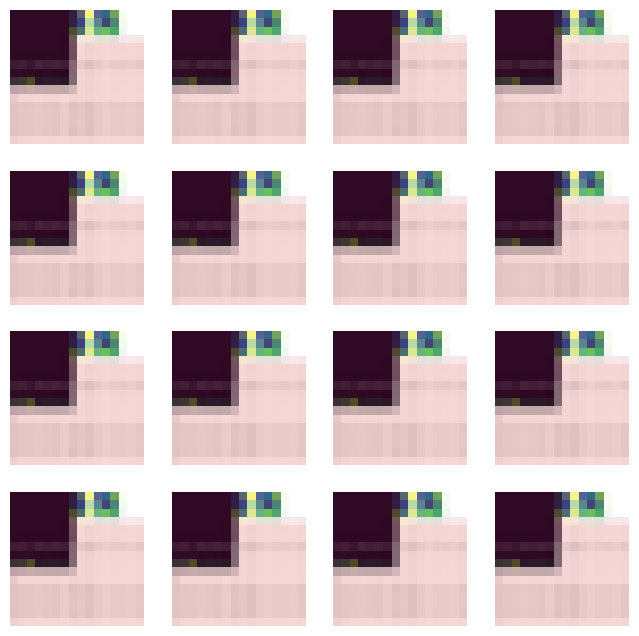

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..0.9137255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7254902..0.654902].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.64705884].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7882353..0.62352943].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.8745098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..

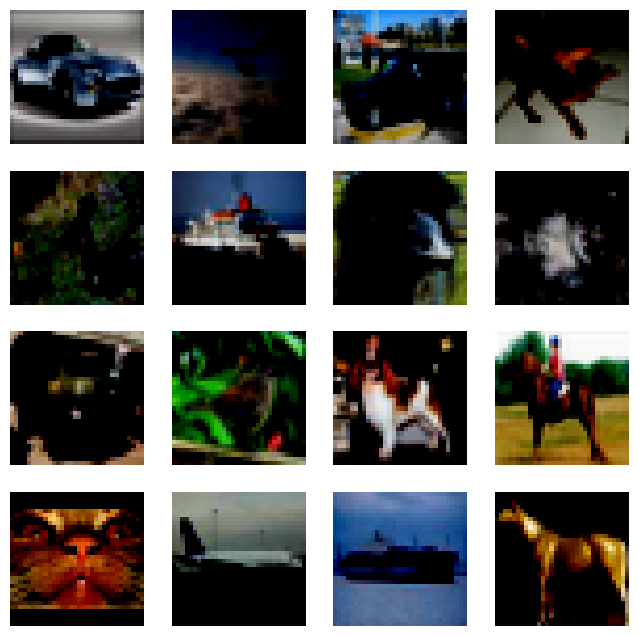

grey shape:  torch.Size([3, 16, 16])


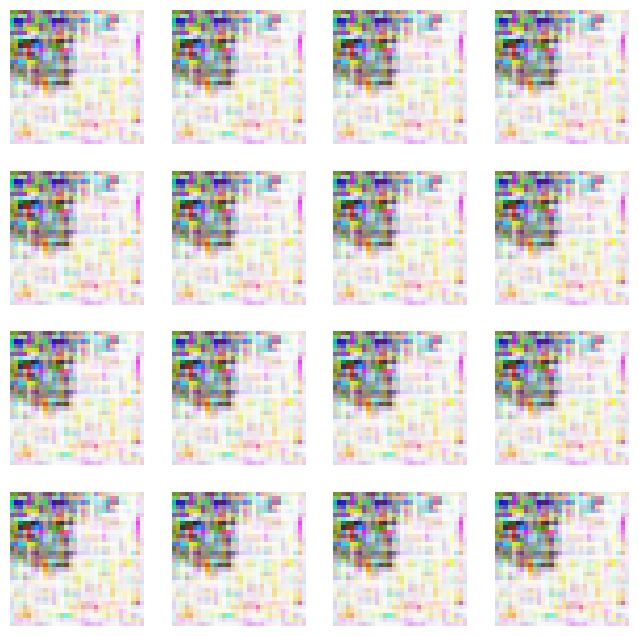

In [53]:
#@title 验证模型

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


def load_image(image_path, img_shape):
    # 使用 Pillow 加载图像
    image = Image.open(image_path).convert('RGB')
    # 将图像调整为所需的尺寸
    image = image.resize((img_shape[1], img_shape[2]))
    # 转换为 Tensor
    transform = transforms.ToTensor()
    image = transform(image)
    # 转换为灰度图像
    # image = torch.mean(image, dim=0, keepdim=True)  # 灰度图像
    return image

def save_generated_images(generator, epoch, latent_dim, num_classes, img_shape):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(64, latent_dim).to(device)
        labels = torch.randint(0, num_classes, (16,)).to(device)

        # # 使用 DataLoader 迭代器
        # dataiter = iter(train_loader)
        # test_imgs, test_labels = next(dataiter)

        # real_imgs = test_imgs.to(device)
        # grey_imgs = torch.mean(real_imgs, dim=1, keepdim=True).to(device)

        # 从本地加载图像
        grey_imgs = load_image("ok.png", img_shape).unsqueeze(0).to(device)
        grey_imgs = grey_imgs.repeat(64, 1, 1, 1)  # 扩展为批量大小为 64
        grey_imgs = F.interpolate(grey_imgs, scale_factor=0.5, mode='bilinear', align_corners=False).to(device)
        gen_imgs = generator(z, grey_imgs)

        # gen_imgs = generator(z, torch.mean(torch.randn(16, 3, img_shape[1], img_shape[2]), dim=1, keepdim=True).to(device))
        gen_imgs = (gen_imgs + 1) / 2  # Rescale images from [-1, 1] to [0, 1]

        fig, axs = plt.subplots(4, 4, figsize=(8, 8))
        cnt = 0
        for i in range(4):
            for j in range(4):
                axs[i, j].imshow(np.transpose(grey_imgs[cnt].cpu().numpy(), (1, 2, 0)))
                axs[i, j].axis('off')
                cnt += 1
        plt.savefig(f'images/{epoch}.png')
        plt.show()

        fig, axs = plt.subplots(4, 4, figsize=(8, 8))
        cnt = 0
        for i in range(4):
            for j in range(4):
                axs[i, j].imshow(np.transpose(real_imgs[cnt].cpu().numpy(), (1, 2, 0)))
                axs[i, j].axis('off')
                cnt += 1
        plt.savefig(f'images/{epoch}.png')
        plt.show()

        print("grey shape: ", grey_imgs[0].shape)
        fig, axs = plt.subplots(4, 4, figsize=(8, 8))
        cnt = 0
        for i in range(4):
            for j in range(4):
                axs[i, j].imshow(np.transpose(gen_imgs[cnt].cpu().numpy(), (1, 2, 0)))
                axs[i, j].axis('off')
                cnt += 1
        plt.savefig(f'images/{epoch}.png')
        plt.show()

# Example usage:
save_generated_images(generator, epoch, latent_dim, num_classes, img_shape)
